## TO DO List
#### Learn more about DatasetSplit 
#### Implement KD with TA
#### Reduce time for training 

# Libraries and Data Preparation

In [ ]:
%%capture
! apt-get install libavformat-dev libavdevice-dev
! pip install av==6.2.0
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
! wget https://raw.githubusercontent.com/pytorch/vision/6de158c473b83cf43344a0651d7c01128c7850e6/references/video_classification/transforms.py
import transforms as T

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import get_video_backend, transforms
from torchvision.models.video import r3d_18 
import os
from tqdm.auto import tqdm
import numpy as np
import time
import av
import random
print(f"PyAV version -- {av.__version__}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)

import copy
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot as plt
%matplotlib inline

PyAV version -- 6.2.0
Using device: cuda


In [ ]:
! mkdir -p video_data test_train_splits
! unrar e test_train_splits.rar test_train_splits
! rm test_train_splits.rar
! unrar e hmdb51_org.rar 
! rm hmdb51_org.rar
! mv *.rar video_data
for files in os.listdir('video_data'):
    foldername = files.split('.')[0]
    os.system("mkdir -p video_data/" + foldername)
    os.system("unrar e video_data/"+ files + " video_data/"+foldername)

! rm video_data/*.rar 


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  test_train_splits/brush_hair_test_split1.txt                   0%  OK 
Extracting  test_train_splits/brush_hair_test_split2.txt                   1%  OK 
Extracting  test_train_splits/brush_hair_test_split3.txt                   1%  OK 
Extracting  test_train_splits/cartwheel_test_split1.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split2.txt                    2%  OK 
Extracting  test_train_splits/cartwheel_test_split3.txt                    3%  OK 
Extracting  test_train_splits/catch_test_split1.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split2.txt                        4%  OK 
Extracting  test_train_splits/catch_test_split3.txt                        5%  OK 
Extracting  test_train_splits/chew_test_split1.txt              

In [ ]:
def run_av_diagnostics():
    import av
    av.open("video_data/brush_hair/Aussie_Brunette_Brushing_Hair_II_brush_hair_u_nm_np1_ba_goo_4.avi")
    print(get_video_backend())
    av.logging.set_level(av.logging.ERROR)
    if not hasattr(av.video.frame.VideoFrame, 'pict_type'):
      print("Nah")

run_av_diagnostics()

pyav


# Parameters

In [ ]:
num_communication = 1
num_local_update = 1
num_edge_aggregation = 1
lr = 0.01
num_clients = 4
num_edges = 2
bs_train = 8
bs_test = 32
decay_reg = 0.002
num_frames = 16
clip_steps = 25
num_workers = 8
pin_memory = True
kwargs = {'num_workers':num_workers, 'pin_memory':True} if torch.cuda.is_available() else {'num_workers':num_workers}

# Model

In [ ]:
class VideoRecog_Model(nn.Module):
  def __init__(self):
      super(VideoRecog_Model, self).__init__()
      self.base_model = nn.Sequential(*list(r3d_18(pretrained=True).children())[:-1])
      self.fc = nn.Linear(512, 51)
  def forward(self, x):
      out = self.base_model(x).squeeze(4).squeeze(3).squeeze(2)
      out = torch.log_softmax(self.fc(out), dim=1)
      return out

def set_parameters(model):
    for param in model.parameters():
        param.requires_grad = False

global_nn = VideoRecog_Model().to(device)
set_parameters(global_nn)
print(global_nn)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth



VideoRecog_Model(
  (base_model): Sequential(
    (0): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

out = global_nn(torch.randn(16, 3 , 8, 112,112).cuda())
print(count_parameters(global_nn))
out.size()

0


torch.Size([16, 51])

# Average Weights

In [ ]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def update_acc(self, val, n=1):
        self.val = val/n
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def average_weights(w, s_num):
    total_sample_num = sum(s_num)
    temp_sample_num = s_num[0]
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():  
        for i in range(1, len(w)): 
            w_avg[k] = w_avg[k] + torch.mul(w[i][k], s_num[i]/temp_sample_num)
        w_avg[k] = torch.mul(w_avg[k], temp_sample_num/total_sample_num)
    return w_avg

# Cloud

In [ ]:
class Cloud():
    def __init__(self, layers):
        self.receiver_buffer = {}
        self.state_dict = {}
        self.id_registration = []
        self.sample_registration = {}
    def refresh_cloudserver(self):
        self.receiver_buffer.clear()
        del self.id_registration[:]
        self.sample_registration.clear()
        return None
    def edge_register(self, edge):
        self.id_registration.append(edge.id)
        self.sample_registration[edge.id] = edge.all_trainsample_num
        return None
    def receive_from_edge(self, edge_id, e_state_dict):
        self.receiver_buffer[edge_id] = e_state_dict
        return None
    def aggregate(self):
        received_dict = [dict for dict in self.receiver_buffer.values()]
        sample_num = [snum for snum in self.sample_registration.values()]
        self.state_dict = average_weights(w=received_dict,s_num=sample_num)
        return None
    def send_to_edge(self, edge): 
        edge.receive_from_cloudserver(copy.deepcopy(self.state_dict))
        return None

# Edge

In [ ]:
class Edge():
    def __init__(self, id, cids, layers):
        self.id = id
        self.cids = cids
        self.receiver_buffer = {}
        self.state_dict = {}
        self.id_registration = []
        self.sample_registration = {}
        self.all_trainsample_num = 0
        self.state_dict = layers
    def refresh_edgeserver(self):
        self.receiver_buffer.clear()
        del self.id_registration[:]
        self.sample_registration.clear()
        return None
    def client_register(self, client):
        self.id_registration.append(client.id)
        self.sample_registration[client.id] = len(client.train_loader.dataset)
        return None
    def receive_from_client(self, client_id, c_state_dict):
        self.receiver_buffer[client_id] = c_state_dict
        return None
    def aggregate(self):
        received_dict = [dict for dict in self.receiver_buffer.values()]
        sample_num = [snum for snum in self.sample_registration.values()]
        self.state_dict = average_weights(w = received_dict,s_num= sample_num)
    def send_to_client(self, client):
        client.receive_from_edgeserver(copy.deepcopy(self.state_dict))
        return None
    def send_to_cloudserver(self, cloud):
        cloud.receive_from_edge(edge_id=self.id,e_state_dict= copy.deepcopy(self.state_dict))
        return None
    def receive_from_cloudserver(self, state_dict):
        self.state_dict = state_dict
        return None

# Client

In [ ]:
class Client():
    def __init__(self, id, train_loader, device):
        self.id = id
        self.train_loader = train_loader
        self.model = VideoRecog_Model().to(device)
        self.set_parameter_requires_grad_video(self.model)
        self.receiver_buffer = {}
        self.batch_size_train = bs_train
    def set_parameter_requires_grad_video(self, model):
        for param in model.parameters():
            param.requires_grad = False
        model.fc.weight.requires_grad = True
        model.fc.bias.requires_grad = True
    def local_update(self):
        self.model.train()
        correct, total_loss, flag = 0, 0.0, 0
        Loss, Acc = AverageMeter(), AverageMeter()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=decay_reg)
        start = time.time()
        #print("1")
        for epoch in range(num_local_update):  
            for batch_id, data in enumerate(self.train_loader):
                data, target = data[0].to(device), data[-1].to(device)
                #print("2")
                optimizer.zero_grad()
                output = self.model(data)
                loss = F.nll_loss(output, target)
                total_loss += loss.item()
                loss.backward()
                optimizer.step()
                Loss.update(loss.item(), data.size(0))
                pred = output.argmax(dim=1, keepdim=True)
                num_corrects = pred.eq(target.view_as(pred)).sum().item()
                correct += num_corrects
                Acc.update_acc(num_corrects, data.size(0))
                print("I am running yay")
            total_loss /= len(self.train_loader.dataset)
            print("Epoch {}".format(epoch)) 
        print(f"Takes {time.time() - start}")        
        return total_loss 
    def send_to_edgeserver(self, edgeserver):
        edgeserver.receive_from_client(client_id= self.id,c_state_dict = copy.deepcopy(self.model.state_dict()))
        return None
    def receive_from_edgeserver(self, state_dict):
        self.receiver_buffer = state_dict
        return None
    def update_model(self, new_layers):
        self.model.load_state_dict(new_layers)
    def sync_with_edgeserver(self):
        self.model.load_state_dict(self.receiver_buffer)
        return None

# HierFL Dataset Split

In [ ]:
train_tfms = torchvision.transforms.Compose([
                                 T.ToFloatTensorInZeroOne(),
                                 T.Resize((128, 171)),
                                 T.RandomHorizontalFlip(),
                                 T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                 T.RandomCrop((112, 112))
                               ])  
test_tfms =  torchvision.transforms.Compose([
                                             T.ToFloatTensorInZeroOne(),
                                             T.Resize((128, 171)),
                                             T.Normalize(mean=[0.43216, 0.394666, 0.37645], std=[0.22803, 0.22145, 0.216989]),
                                             T.CenterCrop((112, 112))
                                             ])
hmdb51_train = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,
                                                step_between_clips = clip_steps, fold=1, train=True,
                                                transform=train_tfms, num_workers=num_workers)
hmdb51_test = torchvision.datasets.HMDB51('video_data/', 'test_train_splits/', num_frames,
                                                step_between_clips = clip_steps, fold=1, train=False,
                                                transform=test_tfms, num_workers=num_workers)
total_train_samples = len(hmdb51_train)
print(f"number of train samples {total_train_samples}")
print(f"number of test samples {len(hmdb51_test)}")


number of train samples 13396
number of test samples 5551


In [ ]:
class DatasetSplit(Dataset):
    def __init__(self, dataset, idxs):
        super(DatasetSplit, self).__init__()
        self.dataset = dataset
        self.idxs = list(idxs)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, item):
        data = self.dataset[self.idxs[item]]
        return data

In [ ]:
train_loaders = [0] * num_clients
num_samples_per_client = int(total_train_samples / num_clients)
all_idxs = [i for i in range(total_train_samples)]  
for i in range(num_clients):
    idxs = np.random.choice(all_idxs, num_samples_per_client, replace = False)
    all_idxs = list(set(all_idxs) - set(idxs))
    train_loaders[i] = DataLoader(DatasetSplit(hmdb51_train, idxs), batch_size = bs_train, shuffle = True, **kwargs)

test_loader  = DataLoader(hmdb51_test, batch_size=bs_test, shuffle=False, **kwargs)
print(len(train_loaders[0].dataset))

3349


# HierFL Test Loop

In [ ]:
def test(model, loader):
  model.eval()
  correct = 0
  total_loss = 0.0
  Loss, Acc = AverageMeter(), AverageMeter()
  with torch.no_grad():
    for batch_id, data in enumerate(loader):
      data, target = data[0], data[-1]
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = F.nll_loss(output, target)
      total_loss += loss.item()
      Loss.update(loss.item(), data.size(0))
      pred = output.argmax(dim=1, keepdim=True)  
      num_corrects = pred.eq(target.view_as(pred)).sum().item()
      correct += num_corrects
      Acc.update_acc(num_corrects, data.size(0))
    total_loss /= len(loader.dataset)
    print(' Average Loss: {:.6f} Average Accuracy: {}/{} ({:.3f})%'.format(Loss.avg, correct, Acc.count , 100. * Acc.avg ))
    return total_loss, 100. * Acc.avg

# Main HierFL Algorithm

In [ ]:
avg_acc_v_total = []
client_loss_total = []
clients = []
edges = []

print("Hierarchical Federated Learning Started")
for i in range(num_clients):
    clients.append(Client(id=i,train_loader=train_loaders[i],device=device))
cids = np.arange(num_clients)
clients_per_edge = int(num_clients / num_edges)
print("Clients initialized")

for i in range(num_edges):
    selected_cids = np.random.choice(cids, clients_per_edge, replace=False)
    cids = list (set(cids) - set(selected_cids))
    edges.append(Edge(id = i,cids = selected_cids,layers = copy.deepcopy(clients[0].model.state_dict())))
    [edges[i].client_register(clients[cid]) for cid in selected_cids]
    edges[i].all_trainsample_num = sum(edges[i].sample_registration.values())
    edges[i].refresh_edgeserver()

cloud = Cloud(layers=copy.deepcopy(clients[0].model.state_dict()))
print("Cloud and edge servers initialized")

Hierarchical Federated Learning Started
Clients initialized
Cloud and edge servers initialized


In [ ]:
print("Starting Training")
for num_comm in tqdm(range(num_communication)):
    start = time.time()
    cloud.refresh_cloudserver()
    [cloud.edge_register(edge=edge) for edge in edges]
    print("Edge aggregation started")
    for num_edgeagg in range(num_edge_aggregation):
        client_loss = 0.0
        for i,edge in enumerate(edges):
            edge.refresh_edgeserver()
            selected_cids = edge.cids
            for selected_cid in selected_cids:
                edge.client_register(clients[selected_cid])
            for selected_cid in selected_cids:
                edge.send_to_client(clients[selected_cid])
                clients[selected_cid].sync_with_edgeserver()
                client_loss += clients[selected_cid].local_update()
                clients[selected_cid].send_to_edgeserver(edge)
                client_loss_total.append(client_loss) 
            edge.aggregate()   
    print("Edge interaction ended")
    for edge in edges:
        edge.send_to_cloudserver(cloud)
    cloud.aggregate()
    for edge in edges:
        cloud.send_to_edge(edge)
    print("Interaction with cloud ended")
    global_nn.load_state_dict(state_dict = copy.deepcopy(cloud.state_dict))
    tot_loss, avg_acc_v = test(global_nn, test_loader)
    print("Epoch {} took {} seconds".format(num_comm+1, time.time()-start))
    avg_acc_v_total.append([avg_acc_v, num_comm + 1])
    if (num_comm+1)%3 == 0:
        lr = lr*0.05
        print("Learning rate is now {}".format(lr))

Starting Training


Edge aggregation started
Epoch 0
Takes 139.18087315559387
Epoch 0
Takes 139.0233976840973
Edge interaction ended
Interaction with cloud ended
 Average Loss: 2.073229 Average Accuracy: 2612/5551 (47.055)%
Epoch 1 took 498.8556299209595 seconds



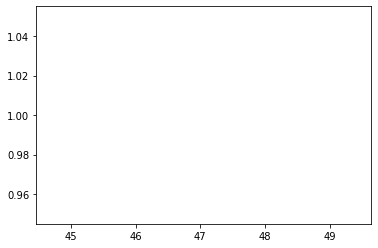

In [ ]:
x = []
y = []
for i in avg_acc_v_total:
    x.append(i[1])
    y.append(i[0])
plt.plot(x,y)
plt.show()